# Identifying authors - Who wrote that?
Started on 30 Oct 2017

This notebook is inspired by:
* Machine Learning: Classification - Coursera course by University of Washington,
https://www.coursera.org/learn/ml-classification
* Machine Learning with Text in scikit-learn - Kevin Markham's tutorial at Pycon 2016, 
https://m.youtube.com/watch?t=185s&v=ZiKMIuYidY0
* Kernel by bshivanni - "Predict the author of the story", 
https://www.kaggle.com/bsivavenu/predict-the-author-of-the-story
* Kernel by SRK - "Simple Engg Feature Notebook - Spooky Author",
https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

Comments:

* In this kernel, I did a weighted averaging of the 'proba' of the 2 models to see the performance.
* I added character counts as features to the sparse matrix to see if prediction performance will improve.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Read "train.csv" and "test.csv into pandas

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Examine the train data

In [3]:
# check the class distribution for the author label in train_df?
train_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

#### The class distribution looks balanced.

In [4]:
# compute the character length for the rows and record these
train_df['text_length'] = train_df['text'].str.len()

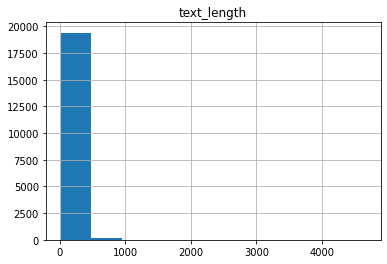

In [5]:
# look at the histogram plot for text length
train_df.hist()
plt.show()

#### Most of the text length are 500 characters and less. Let's look at the summary statistics of the text lengths by author.

In [6]:
EAP = train_df[train_df['author'] =='EAP']['text_length']
EAP.describe()

count    7900.000000
mean      142.225949
std       105.751334
min        21.000000
25%        68.000000
50%       115.000000
75%       186.000000
max      1533.000000
Name: text_length, dtype: float64

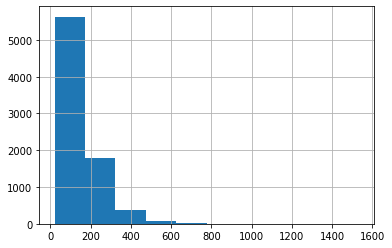

In [7]:
EAP.hist()
plt.show()

In [8]:
MWS = train_df[train_df['author'] == 'MWS']['text_length']
MWS.describe()

count    6044.000000
mean      151.659828
std       126.305008
min        21.000000
25%        84.000000
50%       130.000000
75%       192.000000
max      4663.000000
Name: text_length, dtype: float64

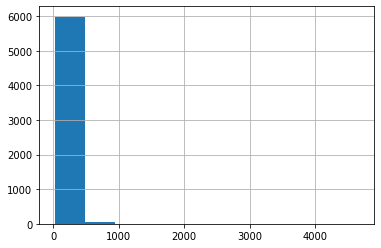

In [9]:
MWS.hist()
plt.show()

In [10]:
HPL = train_df[train_df['author'] == 'HPL']['text_length']
HPL.describe()

count    5635.000000
mean      155.843478
std        82.020647
min        21.000000
25%        98.000000
50%       142.000000
75%       196.500000
max       900.000000
Name: text_length, dtype: float64

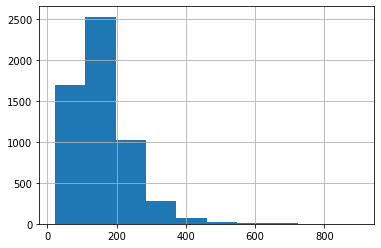

In [11]:
HPL.hist()
plt.show()

## Similarly examine the text length & distribution in test data

In [12]:
# examine the text characters length in test_df and record these
test_df['text_length'] = test_df['text'].str.len()

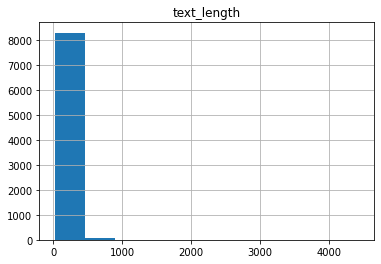

In [13]:
test_df.hist()
plt.show()

#### The proportion of text which are long in the test data is very similar to that in the train data.

## Some preprocessing of the target variable to facilitate modelling

In [14]:
# convert author labels into numerical variables
train_df['author_num'] = train_df.author.map({'EAP':0, 'HPL':1, 'MWS':2})
# Check conversion for first 5 rows
train_df.head()

,id,text,author,text_length,author_num
0,id26305,"This process, however, afforded me no means of...",EAP,231,0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,1


#### Let's limit all text length to 700 characters for both train and test (for less outliers in data).

In [15]:
train_df = train_df.rename(columns={'text':'original_text'})
train_df['text'] = train_df['original_text'].str[:700]
train_df['text_length'] = train_df['text'].str.len()

In [16]:
test_df = test_df.rename(columns={'text':'original_text'})
test_df['text'] = test_df['original_text'].str[:700]
test_df['text_length'] = test_df['text'].str.len()

## Define X and y from train data for use in tokenization by Vectorizers

In [17]:
X = train_df['text']
y = train_df['author_num']

## Split train data into a training and a test set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15663,) (15663,) (3916,) (3916,)


In [19]:
# examine the class distribution in y_train and y_test
print(y_train.value_counts(),'\n', y_test.value_counts())

0    6330
2    4800
1    4533
Name: author_num, dtype: int64 
 0    1570
2    1244
1    1102
Name: author_num, dtype: int64


## Vectorize the data using Vectorizer

In [20]:
# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# vect = CountVectorizer()
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b')
vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\;|\:')
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\?|\;|\:|\!|\'')
vect

CountVectorizer(lowercase=False, token_pattern='(?u)\\b\\w+\\b|\\,|\\.|\\;|\\:')

In [21]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm

<15663x25149 sparse matrix of type '<class 'numpy.int64'>'
	with 390889 stored elements in Compressed Sparse Row format>

In [22]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_dtm

<3916x25149 sparse matrix of type '<class 'numpy.int64'>'
	with 94477 stored elements in Compressed Sparse Row format>

### Add character counts as a features to the sparse matrix using function `add_feature`

In [23]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [24]:
from string import punctuation
X_train_chars = X_train.str.len()
X_train_punc = X_train.apply(lambda x: len([c for c in str(x) if c in punctuation]))
X_test_chars = X_test.str.len()
X_test_punc = X_test.apply(lambda x: len([c for c in str(x) if c in punctuation]))
X_train_dtm = add_feature(X_train_dtm, [X_train_chars, X_train_punc])
X_test_dtm = add_feature(X_test_dtm, [X_test_chars, X_test_punc])

In [25]:
X_train_dtm

<15663x25151 sparse matrix of type '<class 'numpy.int64'>'
	with 422211 stored elements in Compressed Sparse Row format>

In [26]:
X_test_dtm

<3916x25151 sparse matrix of type '<class 'numpy.int64'>'
	with 102308 stored elements in Compressed Sparse Row format>

## Build and evaluate an author classification model using Multinomial Naive Bayes

In [27]:
# import and instantiate the Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb

MultinomialNB()

In [28]:
# tune hyperparameter alpha = [0.01, 0.1, 1, 10, 100]
from sklearn.model_selection import GridSearchCV
grid_values = {'alpha':[0.01, 0.1, 1.0, 10.0, 100.0]}
grid_nb = GridSearchCV(nb, param_grid=grid_values, scoring='neg_log_loss')
grid_nb.fit(X_train_dtm, y_train)
grid_nb.best_params_

{'alpha': 1.0}

In [29]:
# set with recommended hyperparameters
nb = MultinomialNB(alpha=1.0)
# train the model using X_train_dtm & y_train
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [30]:
# make author (class) predictions for X_test_dtm
y_pred_test = nb.predict(X_test_dtm)

In [31]:
# compute the accuracy of the predictions with y_test
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_test)

0.8465270684371808

In [32]:
# compute the accuracy of training data predictions
y_pred_train = nb.predict(X_train_dtm)
metrics.accuracy_score(y_train, y_pred_train)

0.9204494668965076

In [33]:
# look at the confusion matrix for y_test
metrics.confusion_matrix(y_test, y_pred_test)

array([[1334,   86,  150],
       [ 121,  888,   93],
       [ 110,   41, 1093]])

In [34]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)
y_pred_prob[:10]

array([[1.20639349e-03, 3.99802460e-03, 9.94795582e-01],
       [8.32407436e-03, 9.64229670e-03, 9.82033629e-01],
       [9.99992933e-01, 6.98915402e-06, 7.81255070e-08],
       [1.43669556e-02, 9.68078768e-01, 1.75542762e-02],
       [9.94550767e-01, 5.42714704e-03, 2.20855819e-05],
       [9.99996933e-01, 3.05641025e-06, 1.02565395e-08],
       [9.98182958e-01, 1.05582522e-05, 1.80648413e-03],
       [4.05684542e-04, 9.69755683e-01, 2.98386322e-02],
       [5.10049389e-01, 3.09658018e-02, 4.58984809e-01],
       [8.32947731e-02, 8.06978732e-01, 1.09726495e-01]])

In [35]:
# compute the log loss number
metrics.log_loss(y_test, y_pred_prob)

0.4526353464718414

## Build and evaluate an author classification model using Logistic Regression

In [36]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=8)
logreg

LogisticRegression(random_state=8)

In [37]:
# tune hyperparameter
grid_values = {'C':[0.01, 0.1, 1.0, 3.0, 5.0]}
grid_logreg = GridSearchCV(logreg, param_grid=grid_values, scoring='neg_log_loss')
grid_logreg.fit(X_train_dtm, y_train)
grid_logreg.best_params_

/home/nakamura/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nakamura/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

{'C': 5.0}

In [38]:
# set with recommended parameter
logreg = LogisticRegression(C=1.0, random_state=8)
# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)

/home/nakamura/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=8)

In [39]:
# make class predictions for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)

In [40]:
# compute the accuracy of the predictions
metrics.accuracy_score(y_test, y_pred_test)

0.6940755873340143

In [41]:
# compute the accuracy of predictions with the training data
y_pred_train = logreg.predict(X_train_dtm)
metrics.accuracy_score(y_train, y_pred_train)

0.714422524420609

In [42]:
# look at the confusion matrix for y_test
metrics.confusion_matrix(y_test, y_pred_test)

array([[1222,  145,  203],
       [ 278,  687,  137],
       [ 306,  129,  809]])

In [43]:
# compute the predicted probabilities for X_test_dtm
y_pred_prob = logreg.predict_proba(X_test_dtm)
y_pred_prob[:10]

array([[0.33453882, 0.08518897, 0.58027221],
       [0.14217317, 0.26359765, 0.59422918],
       [0.54552891, 0.43919177, 0.01527932],
       [0.48233173, 0.43026152, 0.08740675],
       [0.19611046, 0.60349498, 0.20039456],
       [0.43863703, 0.55793361, 0.00342935],
       [0.48638422, 0.14406109, 0.36955469],
       [0.55260589, 0.09903998, 0.34835412],
       [0.32508389, 0.2460588 , 0.42885731],
       [0.380913  , 0.21034139, 0.4087456 ]])

In [44]:
# compute the log loss number
metrics.log_loss(y_test, y_pred_prob)

0.7320566012572831

## Train the Logistic Regression model with the entire dataset from "train.csv"

In [45]:
# Learn the vocabulary in the entire training data, and create the document-term matrix
X_dtm = vect.fit_transform(X)
# Examine the document-term matrix created from X_train
X_dtm

<19579x27457 sparse matrix of type '<class 'numpy.int64'>'
	with 487900 stored elements in Compressed Sparse Row format>

In [46]:
# Add character counts features
X_chars = X.str.len()
X_punc = X.apply(lambda x: len([c for c in str(x) if c in punctuation]))
X_dtm = add_feature(X_dtm, [X_chars, X_punc])
X_dtm

<19579x27459 sparse matrix of type '<class 'numpy.int64'>'
	with 527053 stored elements in Compressed Sparse Row format>

In [47]:
# Train the Logistic Regression model using X_dtm & y
logreg.fit(X_dtm, y)

/home/nakamura/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=8)

In [48]:
# Compute the accuracy of training data predictions
y_pred_train = logreg.predict(X_dtm)
metrics.accuracy_score(y, y_pred_train)

0.7037642371929108

## Make predictions on the test data and compute the probabilities for submission

In [49]:
test = test_df['text']
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_dtm = vect.transform(test)
# examine the document-term matrix from X_test
test_dtm

<8392x27457 sparse matrix of type '<class 'numpy.int64'>'
	with 203241 stored elements in Compressed Sparse Row format>

In [50]:
# Add character counts features
test_chars = test.str.len()
test_punc = test.str.count(r'\W')
test_dtm = add_feature(test_dtm, [test_chars, test_punc])
test_dtm

<8392x27459 sparse matrix of type '<class 'numpy.int64'>'
	with 220025 stored elements in Compressed Sparse Row format>

In [51]:
# make author (class) predictions for test_dtm
LR_y_pred = logreg.predict(test_dtm)
print(LR_y_pred)

[0 0 0 ... 0 0 0]


In [52]:
# calculate predicted probabilities for test_dtm
LR_y_pred_prob = logreg.predict_proba(test_dtm)
LR_y_pred_prob[:10]

array([[9.88193555e-01, 1.05196410e-02, 1.28680360e-03],
       [9.99998638e-01, 1.36195431e-06, 1.33358108e-13],
       [8.69848345e-01, 1.30142327e-01, 9.32840578e-06],
       [9.99813812e-01, 1.86174964e-04, 1.33881174e-08],
       [8.69427753e-01, 1.00948558e-01, 2.96236894e-02],
       [9.99950908e-01, 4.90530315e-05, 3.91380829e-08],
       [9.98022780e-01, 1.74881643e-03, 2.28403433e-04],
       [9.66131251e-01, 3.37017511e-02, 1.66997444e-04],
       [9.99377581e-01, 6.22101541e-04, 3.17647100e-07],
       [9.61362440e-01, 2.55941990e-02, 1.30433611e-02]])

## Train the Naive Bayes model with the entire dataset "train.csv"

In [53]:
nb.fit(X_dtm, y)

MultinomialNB()

In [54]:
# compute the accuracy of training data predictions
y_pred_train = nb.predict(X_dtm)
metrics.accuracy_score(y, y_pred_train)

0.9175647377291997

## Make predictions on test data

In [55]:
# make author (class) predictions for test_dtm
NB_y_pred = nb.predict(test_dtm)
print(NB_y_pred)

[2 0 0 ... 0 2 0]


In [56]:
# calculate predicted probablilities for test_dtm
NB_y_pred_prob = nb.predict_proba(test_dtm)
NB_y_pred_prob[:10]

array([[1.07498591e-02, 7.58565047e-07, 9.89249382e-01],
       [1.00000000e+00, 8.91398603e-16, 2.87596702e-12],
       [9.95430753e-01, 4.55817237e-03, 1.10750519e-05],
       [9.99999809e-01, 1.87870429e-07, 2.75662689e-09],
       [9.90005669e-01, 2.33137445e-04, 9.76119392e-03],
       [9.99999878e-01, 5.40447643e-08, 6.76049106e-08],
       [9.99295550e-01, 2.74130306e-04, 4.30319506e-04],
       [1.50533210e-03, 5.49886522e-07, 9.98494118e-01],
       [9.99999996e-01, 3.52726854e-09, 2.18361865e-11],
       [9.87811244e-01, 6.03281072e-04, 1.15854745e-02]])

## Create submission file
#### Here I am combining the probabilities from the two models, using parameter alpha. 

In [57]:
alpha = 0.6
y_pred_prob = ((1-alpha)*LR_y_pred_prob + alpha*NB_y_pred_prob)
y_pred_prob[:10]

array([[4.01727338e-01, 4.20831154e-03, 5.94064351e-01],
       [9.99999455e-01, 5.44781726e-07, 1.77892345e-12],
       [9.45197790e-01, 5.47918341e-02, 1.03763935e-05],
       [9.99925410e-01, 7.45827079e-05, 7.00922310e-09],
       [9.41774502e-01, 4.05193056e-02, 1.77061921e-02],
       [9.99980290e-01, 1.96536394e-05, 5.62181795e-08],
       [9.98786442e-01, 8.64004754e-04, 3.49553077e-04],
       [3.87355700e-01, 1.34810304e-02, 5.99163270e-01],
       [9.99751030e-01, 2.48842733e-04, 1.27071942e-07],
       [9.77231723e-01, 1.05996482e-02, 1.21686292e-02]])

In [61]:
result = pd.DataFrame(y_pred_prob, columns=['EAP','HPL','MWS'])
result.insert(0, 'id', test_df['id'])
result.to_csv('results.csv')

In [59]:
# Generate submission file in csv format
result.to_csv('rhodium_submission_16.csv', index=False, float_format='%.20f')

### Thank you for reading this.
### Comments and tips are most welcomed.
### Please upvote if you find it useful. Cheers!